# Repetition Code Performance

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import sdfec_client

%matplotlib inline

In [2]:
def get_random_symbols(n, snr):
    sigma = 10 ** (-snr/20)
    if isinstance(n, tuple):
        return sigma*np.random.randn(*n)-1
    return sigma*np.random.randn(n)-1

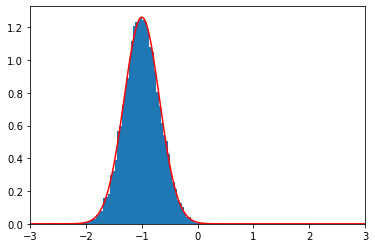

In [3]:
snr = 10
sigma = 10 ** (-snr/20)

plt.hist(get_random_symbols(1024*16, 10), bins=64, density=True);
plt.xlim((-3, 3))
x = np.linspace(-3, 3, 1024)

plt.plot(x, norm.pdf((x+1)/sigma)/sigma, "r");

In [4]:
def bpsk_ber_theory(snr):
    return 1 - norm.cdf(np.sqrt(10**(snr/10)))
    # sigma = 10 ** (-snr/20)
    # return 1-norm.cdf(1/sigma)

In [5]:
def bpsk_ber_sim(n, snrs):
    return np.array([np.count_nonzero(get_random_symbols(n, snr) > 0) / n for snr in snrs])

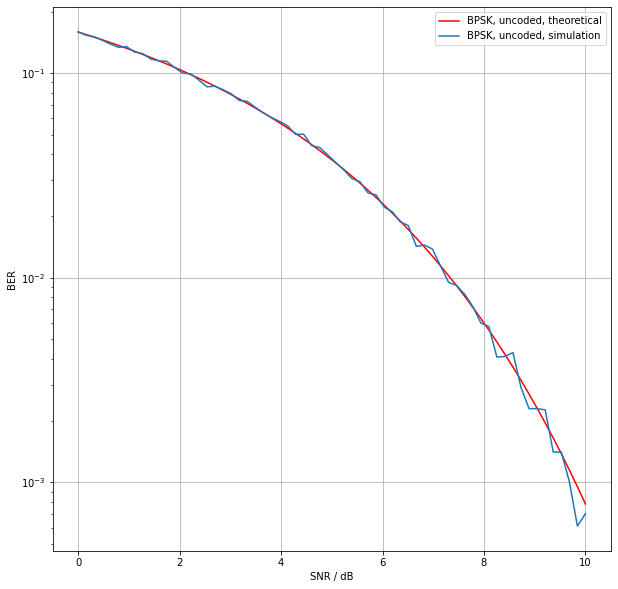

In [6]:
snrs = np.linspace(0, 10, 64)

plt.figure(figsize=(10, 10))
plt.yscale("log")

plt.plot(snrs, bpsk_ber_theory(snrs), "r")
plt.plot(snrs, bpsk_ber_sim(32*1024, snrs))

plt.xlabel("SNR / dB")
plt.ylabel("BER")

plt.legend(["BPSK, uncoded, theoretical", "BPSK, uncoded, simulation"])

plt.grid()

### K-Repetition Code

Theory:

The soft decision ML result is the same as for ordinary BPSK, just applied to the sum of the three corresponding symbols:

BER of K-Repetition Code in AWGN channel with soft decoding:
$$
P_e = Q\left(\sqrt{K * \text{SNR}}\right)
$$

In [7]:
def bpsk_repetition_ber_theory(K, snrs):
    return 1-norm.cdf(np.sqrt(K * 10 ** (snrs/10)))

In [8]:
def bpsk_repetition_ber_sim(K, n, snrs):
    return np.array([np.count_nonzero(np.sum(get_random_symbols((n,K), snr), axis=1) > 0) / n for snr in snrs]) 

### Hardware Setup

In [9]:
client = sdfec_client.SDFECClient("http://localhost:8230/api")

In [10]:
client.status;

In [11]:
repetition_3_code = sdfec_client.parse_yaml("repetition_3.sdfec.yml")

In [12]:
repetition_3_code_id = client.add_code(repetition_3_code)

### Hardware Simulation

In [13]:
repetition_3_snrs = np.linspace(0, 10, 32)
repetition_3_results = client.simulate(repetition_3_code_id, repetition_3_snrs, snr_scales=np.ones_like(repetition_3_snrs)*4, term_time=10, term_errors=1e4, max_iterations=32).wait_progress()

FloatProgress(value=0.0, bar_style='info', description='Running: ', max=1.0)

## Results

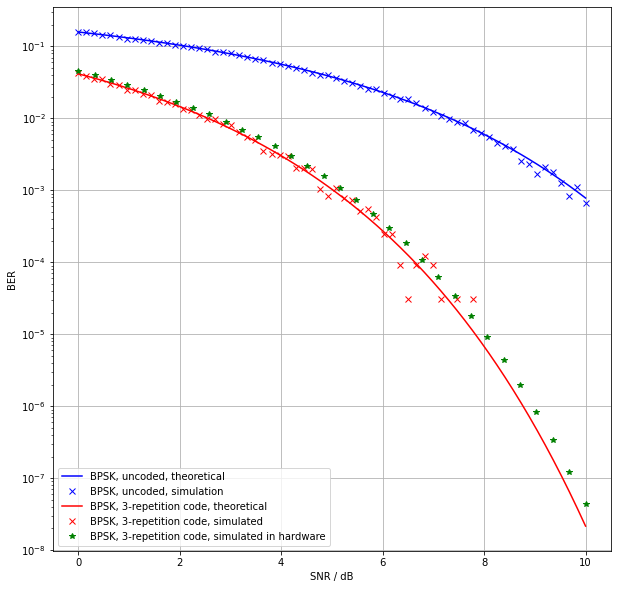

In [14]:
snrs = np.linspace(0, 10, 64)

plt.figure(figsize=(10, 10))
plt.yscale("log")

N = 32*1024

K = 3

plt.plot(snrs, bpsk_ber_theory(snrs), "b")
plt.plot(snrs, bpsk_ber_sim(N, snrs), "bx")

plt.plot(snrs, bpsk_repetition_ber_theory(K, snrs), "r")
plt.plot(snrs, bpsk_repetition_ber_sim(K, N, snrs), "rx")
plt.plot(np.array(repetition_3_results["snrs"]), repetition_3_results["bers"], "g*")

plt.xlabel("SNR / dB")
plt.ylabel("BER")

plt.legend(["BPSK, uncoded, theoretical",
            "BPSK, uncoded, simulation",
            "BPSK, 3-repetition code, theoretical",
            "BPSK, 3-repetition code, simulated",
            "BPSK, 3-repetition code, simulated in hardware"
           ])

plt.grid()

In [15]:
def hw_sim(scale):
    repetition_3_snrs = np.linspace(0, 10, 32)
    return client.simulate(repetition_3_code_id, repetition_3_snrs, snr_scales=np.ones_like(repetition_3_snrs)*scale, term_time=10, term_errors=1e4, max_iterations=32).wait_progress()["bers"]

FloatProgress(value=0.0, bar_style='info', description='Running: ', max=1.0)

FloatProgress(value=0.0, bar_style='info', description='Running: ', max=1.0)

FloatProgress(value=0.0, bar_style='info', description='Running: ', max=1.0)

FloatProgress(value=0.0, bar_style='info', description='Running: ', max=1.0)

FloatProgress(value=0.0, bar_style='info', description='Running: ', max=1.0)

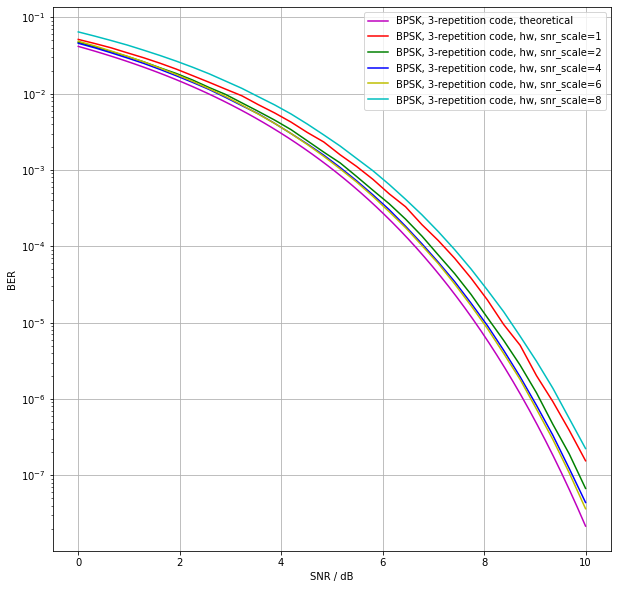

In [16]:
snrs = np.linspace(0, 10, 64)

plt.figure(figsize=(10, 10))
plt.yscale("log")

plt.plot(snrs, bpsk_repetition_ber_theory(K, snrs), "m")
plt.plot(repetition_3_snrs, hw_sim(1), "r")
plt.plot(repetition_3_snrs, hw_sim(2), "g")
plt.plot(repetition_3_snrs, hw_sim(4), "b")
plt.plot(repetition_3_snrs, hw_sim(6), "y")
plt.plot(repetition_3_snrs, hw_sim(8), "c")

plt.xlabel("SNR / dB")
plt.ylabel("BER")

plt.legend(["BPSK, 3-repetition code, theoretical",
            "BPSK, 3-repetition code, hw, snr_scale=1",
            "BPSK, 3-repetition code, hw, snr_scale=2",
            "BPSK, 3-repetition code, hw, snr_scale=4",
            "BPSK, 3-repetition code, hw, snr_scale=6",
            "BPSK, 3-repetition code, hw, snr_scale=8"
           ])

plt.grid()